In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## link_id: 对完整道路按照拓扑切分后得到的小段, 由唯一id标识。

## 1. 道路属性

### 一共有 686104 个 link_id

In [3]:
attr = pd.read_csv('data/attr.csv')
attr

,link_id,length,direction,path_class,speed_class,lane_num,speed_limit,level,width
0,0,19,1,5,7,1,4.166667,5,30
1,1,19,1,5,7,1,4.166667,5,30
2,2,16,1,5,7,1,4.166667,5,30
3,3,16,1,5,7,1,4.166667,5,30
4,4,17,1,5,7,1,4.166667,5,30
...,...,...,...,...,...,...,...,...,...
686100,686100,8,2,4,6,2,13.888889,4,55
686101,686101,37,2,5,7,1,4.166667,5,30
686102,686102,12,2,5,7,1,4.166667,5,30
686103,686103,399,2,3,6,2,13.888889,3,55


In [4]:
attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686105 entries, 0 to 686104
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   link_id      686105 non-null  int64  
 1   length       686105 non-null  int64  
 2   direction    686105 non-null  int64  
 3   path_class   686105 non-null  int64  
 4   speed_class  686105 non-null  int64  
 5   lane_num     686105 non-null  int64  
 6   speed_limit  686105 non-null  float64
 7   level        686105 non-null  int64  
 8   width        686105 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 47.1 MB


In [5]:
attr.describe()

,link_id,length,direction,path_class,speed_class,lane_num,speed_limit,level,width
count,686105.000000,686105.000000,686105.000000,686105.000000,686105.000000,686105.000000,686105.000000,686105.000000,686105.000000
mean,343052.000000,104.681887,1.178051,4.823421,6.754508,1.116813,6.571332,4.823421,45.773643
std,198061.597559,182.245054,0.498129,0.596144,0.800398,0.351027,5.055689,0.596144,17.047070
min,0.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.388889,1.000000,30.000000
25%,171526.000000,24.000000,1.000000,5.000000,7.000000,1.000000,4.166667,5.000000,30.000000
50%,343052.000000,56.000000,1.000000,5.000000,7.000000,1.000000,4.166667,5.000000,55.000000
75%,514578.000000,115.000000,1.000000,5.000000,7.000000,1.000000,4.166667,5.000000,55.000000
max,686104.000000,11459.000000,3.000000,5.000000,8.000000,3.000000,33.333333,5.000000,130.000000


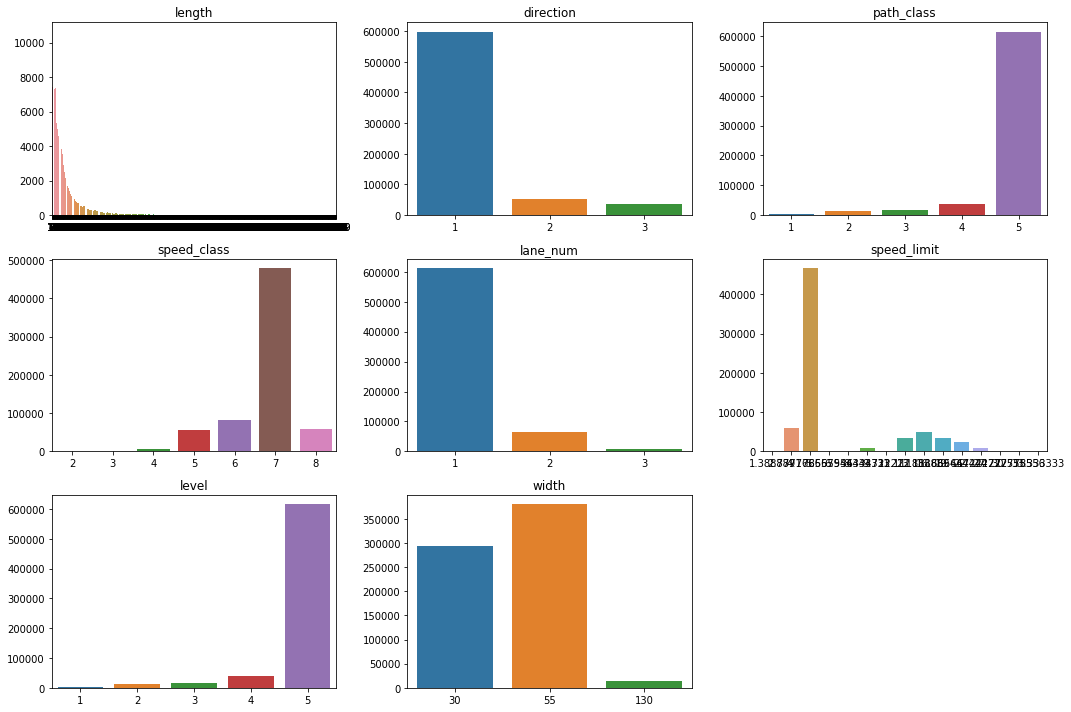

In [5]:
plt.figure(figsize=(15,10))
i = 1
for col in attr.columns.drop('link_id'):
    tmp = attr[col].value_counts()
    plt.subplot(3, 3, i)
    i += 1
    sns.barplot(x=tmp.index, y=tmp.values)    
    plt.title(col)
plt.tight_layout()
plt.show()

## 2. 道路拓扑

### 道路拓扑是有向图

### 源点一共有 683422 < 686104，说明有 2682 个 link_id 是没有下游拓扑结点的。

### 终点一共有 683477 < 686104，说明有 2627 个 link_id 是没有上游拓扑结点的。

In [6]:
link = pd.read_csv('data/link.csv')
link

,link_id,next_link_ids
0,0,1
1,1,"7,2,0"
2,2,3
3,3,"7,2,0"
4,4,"6,5"
...,...,...
683418,686100,649708
683419,686101,686102
683420,686102,685860
683421,686103,686104


In [7]:
next_link_ids = link.next_link_ids.apply(lambda s: [int(x) for x in s.split(',')])
next_ids = []
for x in next_link_ids:
    next_ids.extend(x)
len(set(next_ids))

683477

### 度分布

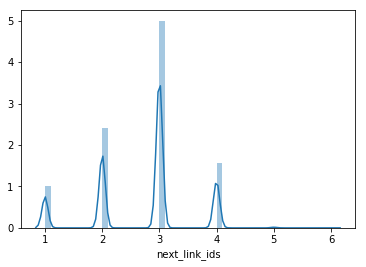

In [8]:
sns.distplot(link.next_link_ids.apply(lambda x: len(x.split(','))))

## 3. 路况数据

### traffic 包括了 20190701 - 20190731 一个月的路况数据，31号是测试集，没有标签。

In [2]:
traffic = pd.read_pickle('data/traffic.pkl')
traffic.head()

,date,link_id,cur_time,pred_time,label,rec_speed_0,rec_speed_1,rec_speed_2,rec_speed_3,rec_speed_4,rec_eta_speed_0,rec_eta_speed_1,rec_eta_speed_2,rec_eta_speed_3,rec_eta_speed_4,rec_car_count_0,rec_car_count_1,rec_car_count_2,rec_car_count_3,rec_car_count_4,rec_label_0,rec_label_1,rec_label_2,rec_label_3,rec_label_4,his_speed_0_0,his_speed_0_1,his_speed_0_2,his_speed_0_3,his_speed_0_4,his_speed_1_0,his_speed_1_1,his_speed_1_2,his_speed_1_3,his_speed_1_4,his_speed_2_0,his_speed_2_1,his_speed_2_2,his_speed_2_3,his_speed_2_4,his_speed_3_0,his_speed_3_1,his_speed_3_2,his_speed_3_3,his_speed_3_4,his_eta_speed_0_0,his_eta_speed_0_1,his_eta_speed_0_2,his_eta_speed_0_3,his_eta_speed_0_4,his_eta_speed_1_0,his_eta_speed_1_1,his_eta_speed_1_2,his_eta_speed_1_3,his_eta_speed_1_4,his_eta_speed_2_0,his_eta_speed_2_1,his_eta_speed_2_2,his_eta_speed_2_3,his_eta_speed_2_4,his_eta_speed_3_0,his_eta_speed_3_1,his_eta_speed_3_2,his_eta_speed_3_3,his_eta_speed_3_4,his_car_count_0_0,his_car_count_0_1,his_car_count_0_2,his_car_count_0_3,his_car_count_0_4,his_car_count_1_0,his_car_count_1_1,his_car_count_1_2,his_car_count_1_3,his_car_count_1_4,his_car_count_2_0,his_car_count_2_1,his_car_count_2_2,his_car_count_2_3,his_car_count_2_4,his_car_count_3_0,his_car_count_3_1,his_car_count_3_2,his_car_count_3_3,his_car_count_3_4,his_label_0_0,his_label_0_1,his_label_0_2,his_label_0_3,his_label_0_4,his_label_1_0,his_label_1_1,his_label_1_2,his_label_1_3,his_label_1_4,his_label_2_0,his_label_2_1,his_label_2_2,his_label_2_3,his_label_2_4,his_label_3_0,his_label_3_1,his_label_3_2,his_label_3_3,his_label_3_4
0,1,1049,258,288,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,43.18750,38.187500,33.59375,27.703125,23.500000,38.50000,38.50000,39.40625,32.59375,32.59375,13.398438,13.398438,13.398438,28.90625,39.3125,30.0000,30.0,33.1875,30.000000,30.000000,23.00000,23.00000,25.90625,22.906250,17.593750,30.09375,30.09375,30.09375,30.09375,30.09375,11.296875,11.296875,11.296875,11.296875,9.601562,9.296875,9.296875,18.90625,17.0,17.0,1,1,2,3,2,1,1,1,1,1,3,3,3,3,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,2,2,2,1,1,0,0,1,0,0
1,1,1049,261,290,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,33.59375,27.703125,23.50000,27.796875,27.796875,39.40625,32.59375,32.59375,32.59375,32.59375,13.398438,28.906250,39.312500,39.31250,39.3125,33.1875,30.0,30.0000,7.699219,7.699219,25.90625,22.90625,17.59375,27.703125,27.703125,30.09375,30.09375,30.09375,30.09375,30.09375,11.296875,11.296875,9.601562,9.601562,9.601562,18.906250,17.000000,17.00000,17.0,17.0,2,3,2,3,3,1,1,1,1,1,3,3,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,0,0,3,3
2,1,1049,264,288,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,43.18750,38.187500,33.59375,27.703125,23.500000,38.50000,38.50000,39.40625,32.59375,32.59375,13.398438,13.398438,13.398438,28.90625,39.3125,30.0000,30.0,33.1875,30.000000,30.000000,23.00000,23.00000,25.90625,22.906250,17.593750,30.09375,30.09375,30.09375,30.09375,30.09375,11.296875,11.296875,11.296875,11.296875,9.601562,9.296875,9.296875,18.90625,17.0,17.0,1,1,2,3,2,1,1,1,1,1,3,3,3,3,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,2,2,2,1,1,0,0,1,0,0
3,1,1049,266,290,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,33.59375,27.703125,23.50000,27.796875,27.796875,39.40625,32.59375,32.59375,32.59375,32.59375,13.398438,28.906250,39.312500,39.31250,39.3125,33.1875,30.0,30.0000,7.699219,7.699219,25.90625,22.90625,17.59375,27.703125,27.703125,30.09375,30.09375,30.09375,30.09375,30.09375,11.296875,11.296875,9.601562,9.601562,9.601562,18.906250,17.000000,17.00000,17.0,17.0,2,3,2,3,3,1,1,1,1,1,3,3,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,0,0,3,3
4,1,1049,272,290,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,33.59375,27.703125,23.50000,27.796875,27.796875,39.40625,32.59375,32.59375,32.59375,32.59375,13.398438,28.906250,39.312500,39.31250,39.3125,33.1875,30.0,30.0000,7.699219,7.699219,25.90625,22.90625,17.59375,27.703125,27.703125,30.09375,30.09375,30.09375,3

### 路况数据中只包括了 14532 个 link_id，14532 << 686104，有很多 link_id 的数据其实是没有公布的

In [11]:
traffic.link_id.nunique()

14532

### 路况数据中每天的路况数据都是在 50w 条上下

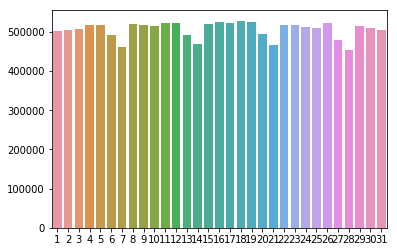

In [12]:
tmp = traffic.date.value_counts()
sns.barplot(x=tmp.index, y=tmp.values)

### 路况的分布情况，1-3 表示拥堵程度

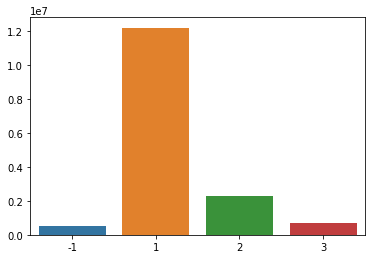

In [13]:
tmp = traffic.label.value_counts()
sns.barplot(x=tmp.index, y=tmp.values)

### 时间片：对时间的离散化描述。一般以2分钟为一个单位，2分钟内认为道路的路况状态是统一的。
### 0-720 时间片表示 0-24 点。
### 负数的时间片表示前一天，说明 cur_time 和 pred_time 之间跨越了零点。

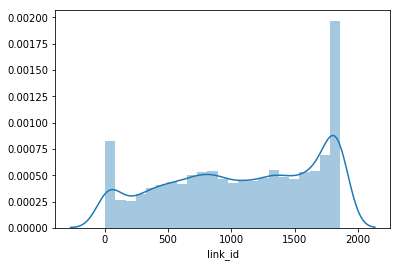

In [8]:
sns.distplot(traffic.link_id.value_counts())

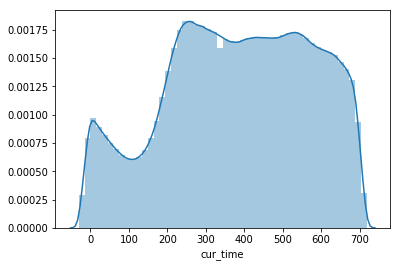

In [15]:
sns.distplot(traffic.cur_time)

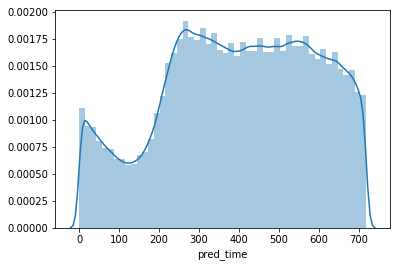

In [16]:
sns.distplot(traffic.pred_time)

### 待预测的时间差从1-30 个时间片不等，也就是最大的时间差是1个小时。

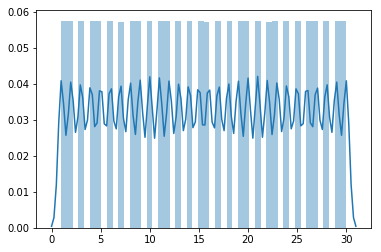

In [17]:
sns.distplot(traffic.pred_time - traffic.cur_time)

In [13]:
traffic.head()

,date,link_id,cur_time,pred_time,label,rec_speed_0,rec_speed_1,rec_speed_2,rec_speed_3,rec_speed_4,rec_eta_speed_0,rec_eta_speed_1,rec_eta_speed_2,rec_eta_speed_3,rec_eta_speed_4,rec_car_count_0,rec_car_count_1,rec_car_count_2,rec_car_count_3,rec_car_count_4,rec_label_0,rec_label_1,rec_label_2,rec_label_3,rec_label_4,his_speed_0_0,his_speed_0_1,his_speed_0_2,his_speed_0_3,his_speed_0_4,his_speed_1_0,his_speed_1_1,his_speed_1_2,his_speed_1_3,his_speed_1_4,his_speed_2_0,his_speed_2_1,his_speed_2_2,his_speed_2_3,his_speed_2_4,his_speed_3_0,his_speed_3_1,his_speed_3_2,his_speed_3_3,his_speed_3_4,his_eta_speed_0_0,his_eta_speed_0_1,his_eta_speed_0_2,his_eta_speed_0_3,his_eta_speed_0_4,his_eta_speed_1_0,his_eta_speed_1_1,his_eta_speed_1_2,his_eta_speed_1_3,his_eta_speed_1_4,his_eta_speed_2_0,his_eta_speed_2_1,his_eta_speed_2_2,his_eta_speed_2_3,his_eta_speed_2_4,his_eta_speed_3_0,his_eta_speed_3_1,his_eta_speed_3_2,his_eta_speed_3_3,his_eta_speed_3_4,his_car_count_0_0,his_car_count_0_1,his_car_count_0_2,his_car_count_0_3,his_car_count_0_4,his_car_count_1_0,his_car_count_1_1,his_car_count_1_2,his_car_count_1_3,his_car_count_1_4,his_car_count_2_0,his_car_count_2_1,his_car_count_2_2,his_car_count_2_3,his_car_count_2_4,his_car_count_3_0,his_car_count_3_1,his_car_count_3_2,his_car_count_3_3,his_car_count_3_4,his_label_0_0,his_label_0_1,his_label_0_2,his_label_0_3,his_label_0_4,his_label_1_0,his_label_1_1,his_label_1_2,his_label_1_3,his_label_1_4,his_label_2_0,his_label_2_1,his_label_2_2,his_label_2_3,his_label_2_4,his_label_3_0,his_label_3_1,his_label_3_2,his_label_3_3,his_label_3_4
0,1,1049,258,288,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,43.18750,38.187500,33.59375,27.703125,23.500000,38.50000,38.50000,39.40625,32.59375,32.59375,13.398438,13.398438,13.398438,28.90625,39.3125,30.0000,30.0,33.1875,30.000000,30.000000,23.00000,23.00000,25.90625,22.906250,17.593750,30.09375,30.09375,30.09375,30.09375,30.09375,11.296875,11.296875,11.296875,11.296875,9.601562,9.296875,9.296875,18.90625,17.0,17.0,1,1,2,3,2,1,1,1,1,1,3,3,3,3,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,2,2,2,1,1,0,0,1,0,0
1,1,1049,261,290,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,33.59375,27.703125,23.50000,27.796875,27.796875,39.40625,32.59375,32.59375,32.59375,32.59375,13.398438,28.906250,39.312500,39.31250,39.3125,33.1875,30.0,30.0000,7.699219,7.699219,25.90625,22.90625,17.59375,27.703125,27.703125,30.09375,30.09375,30.09375,30.09375,30.09375,11.296875,11.296875,9.601562,9.601562,9.601562,18.906250,17.000000,17.00000,17.0,17.0,2,3,2,3,3,1,1,1,1,1,3,3,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,0,0,3,3
2,1,1049,264,288,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,43.18750,38.187500,33.59375,27.703125,23.500000,38.50000,38.50000,39.40625,32.59375,32.59375,13.398438,13.398438,13.398438,28.90625,39.3125,30.0000,30.0,33.1875,30.000000,30.000000,23.00000,23.00000,25.90625,22.906250,17.593750,30.09375,30.09375,30.09375,30.09375,30.09375,11.296875,11.296875,11.296875,11.296875,9.601562,9.296875,9.296875,18.90625,17.0,17.0,1,1,2,3,2,1,1,1,1,1,3,3,3,3,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,2,2,2,1,1,0,0,1,0,0
3,1,1049,266,290,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,33.59375,27.703125,23.50000,27.796875,27.796875,39.40625,32.59375,32.59375,32.59375,32.59375,13.398438,28.906250,39.312500,39.31250,39.3125,33.1875,30.0,30.0000,7.699219,7.699219,25.90625,22.90625,17.59375,27.703125,27.703125,30.09375,30.09375,30.09375,30.09375,30.09375,11.296875,11.296875,9.601562,9.601562,9.601562,18.906250,17.000000,17.00000,17.0,17.0,2,3,2,3,3,1,1,1,1,1,3,3,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,0,0,3,3
4,1,1049,272,290,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,33.59375,27.703125,23.50000,27.796875,27.796875,39.40625,32.59375,32.59375,32.59375,32.59375,13.398438,28.906250,39.312500,39.31250,39.3125,33.1875,30.0,30.0000,7.699219,7.699219,25.90625,22.90625,17.59375,27.703125,27.703125,30.09375,30.09375,30.09375,3

In [16]:
traffic.describe()

,date,link_id,cur_time,pred_time,label,rec_speed_0,rec_speed_1,rec_speed_2,rec_speed_3,rec_speed_4,rec_eta_speed_0,rec_eta_speed_1,rec_eta_speed_2,rec_eta_speed_3,rec_eta_speed_4,rec_car_count_0,rec_car_count_1,rec_car_count_2,rec_car_count_3,rec_car_count_4,rec_label_0,rec_label_1,rec_label_2,rec_label_3,rec_label_4,his_speed_0_0,his_speed_0_1,his_speed_0_2,his_speed_0_3,his_speed_0_4,his_speed_1_0,his_speed_1_1,his_speed_1_2,his_speed_1_3,his_speed_1_4,his_speed_2_0,his_speed_2_1,his_speed_2_2,his_speed_2_3,his_speed_2_4,his_speed_3_0,his_speed_3_1,his_speed_3_2,his_speed_3_3,his_speed_3_4,his_eta_speed_0_0,his_eta_speed_0_1,his_eta_speed_0_2,his_eta_speed_0_3,his_eta_speed_0_4,his_eta_speed_1_0,his_eta_speed_1_1,his_eta_speed_1_2,his_eta_speed_1_3,his_eta_speed_1_4,his_eta_speed_2_0,his_eta_speed_2_1,his_eta_speed_2_2,his_eta_speed_2_3,his_eta_speed_2_4,his_eta_speed_3_0,his_eta_speed_3_1,his_eta_speed_3_2,his_eta_speed_3_3,his_eta_speed_3_4,his_car_count_0_0,his_car_count_0_1,his_car_count_0_2,his_car_count_0_3,his_car_count_0_4,his_car_count_1_0,his_car_count_1_1,his_car_count_1_2,his_car_count_1_3,his_car_count_1_4,his_car_count_2_0,his_car_count_2_1,his_car_count_2_2,his_car_count_2_3,his_car_count_2_4,his_car_count_3_0,his_car_count_3_1,his_car_count_3_2,his_car_count_3_3,his_car_count_3_4,his_label_0_0,his_label_0_1,his_label_0_2,his_label_0_3,his_label_0_4,his_label_1_0,his_label_1_1,his_label_1_2,his_label_1_3,his_label_1_4,his_label_2_0,his_label_2_1,his_label_2_2,his_label_2_3,his_label_2_4,his_label_3_0,his_label_3_1,his_label_3_2,his_label_3_3,his_label_3_4
count,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07,1.568746e+07
mean,1.596753e+01,3.134420e+05,3.821879e+02,3.976885e+02,1.168237e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.346016e+01,1.346620e+01,1.347266e+01,1.348198e+01,1.349438e+01,1.157873e+00,1.158671e+00,1.159844e+00,1.161262e+00,1.163245e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.279161e+01,1.279121e+01,1.279016e+01,1.279141e+01,1.278988e+01,1.305850e+01,1.305809e+01,1.305766e+01,1.305813e+01,1.305769e+01,1.317949e+01,1.317908e+01,1.317860e+01,1.317643e+01,1.317548e+01,1.329235e+01,1.329297e+01,1.329350e+01,1.329416e+01,1.329340e+01,1.135473e+00,1.135667e+00,1.135254e+00,1.135167e+00,1.135283e+00,1.144983e+00,1.145197e+00,1.145067e+00,1.144734e+00,1.144584e+00,1.154656e+00,1.154919e+00,1.154969e+00,1.154652e+00,1.154719e+00,1.160880e+00,1.161084e+00,1.160873e+00,1.160829e+00,1.160461e+00
std,8.920511e+00,1.799297e+05,1.883285e+02,1.881308e+02,6.473191e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.

### 每个 link_id 每天的 pred_time 有且仅对应三个 不同的 cur_time

count    5229155.0
mean           3.0
std            0.0
min            3.0
25%            3.0
50%            3.0
75%            3.0
max            3.0
Name: cur_time, dtype: float64

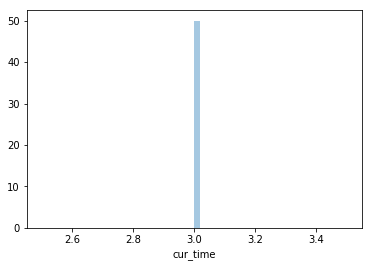

In [6]:
tmp = traffic.groupby(['date', 'link_id', 'pred_time'])['cur_time'].agg('count')
sns.distplot(tmp)
tmp.describe()

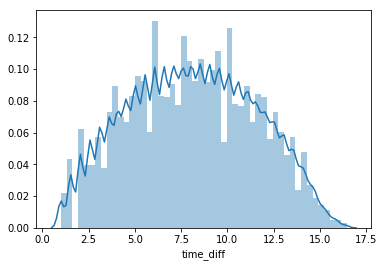

In [9]:
traffic['time_diff'] = traffic.pred_time - traffic.cur_time
tmp = traffic.groupby(['date', 'link_id', 'pred_time'])['time_diff'].agg('std')
sns.distplot(tmp)

### 每个 link_id 每天的 cur_time 大部分值对应一个 pred_time

In [14]:
tmp = traffic.groupby(['date', 'link_id', 'cur_time'])['pred_time'].agg('count')
tmp.describe()

count    1.515923e+07
mean     1.034846e+00
std      1.878066e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      5.000000e+00
Name: pred_time, dtype: float64

### 每天需要预测一个道路的多个 pred_time

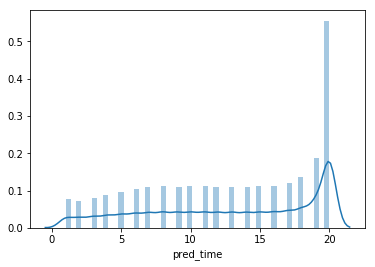

In [18]:
tmp = traffic.groupby(['date', 'link_id'])['pred_time'].agg('nunique')
sns.distplot(tmp)